---
authors: Freek Pols
updated: December 3, 2025
---

# $pV-$ diagram

## Introductie

Wanneer je een gas snel samenperst bij gelijkblijvende volume neemt de Drukeratuur toe. Wanneer je het gas vervolgens laat ontsnappen, neemt de Drukeratuur af omdat het gas arbeid verricht. 

We gaan eigenschappen van dit proces bestuderen. In dit practicum ga je een $p-t$-diagram van een brandblusser bestuderen en gebruiken om de specifieke warmte verhouding $\gamma$ te bepalen voor lucht.

## Experiment (60 min)

In dit experiment vullen we een brandblusser met lucht ($P_1, T_1=T_{atm}$). We laten de lucht snel ontsnappen ($P_2=P_{atm}, T_2$), in zo'n korte tijd dat we aannemen dat dit een adiabatisch proces is. Doordat het gas arbeid verricht zal het gas afkoelen. Wanneer we dan, kort na het ontsnappen van de lucht, de kraan weer dicht doen, zal de druk weer toenemen ($P_3,T_3=T_{atm}$). 

In het eerste deel van het proces geldt: 

$$
  T_1^\gamma P_1^{1-\gamma} = T_2^\gamma P_2^{1-\gamma}
$$

ook wel bekend als ... , met $\gamma$ de specifieke warmte verhouding: $\gamma=\frac{C_p}{C_V}$.

Het tweede deel van het proces kan beschreven worden met de wet van Gay-Lussac:

$$ 
  \frac{P_2}{T_2} = \frac{P_3}{T_3}
$$


Onder de aanname dat $T_1 = T_3 = T_{atm}$ volgt hieruit:

$$
 \gamma=\frac{\ln{P_1}-\ln{P_{atm}}}{\ln{P_1}-\ln{P_3}}
$$

```{exercise}
1. Zet de druksensor in het brandblusapparaat, zet de kraan er op en vul de fles met lucht. 
2. Wacht een tijd (~30 min). Waarom?
3. Knijp in de hendel zodat de lucht ontsnapt. Zodra het lucht niet meer ontsnapt, laat de hendel los zodat er geen uitwisseling van lucht meer is.
4. Wacht een korte tijd en haal dan je Arduino en de sd-kaart uit de blusser.
5. Lees de waarden uit in je eigen python script en bepaalde waarde van $\gamma$. Vergelijk deze met de literatuurwaarde ($\gamma = 1.45$)


Variable               Type        Data/Info
--------------------------------------------
Druk                   ndarray     5015: 5015 elems, type `float64`, 40120 bytes
P1                     float64     753.0
P3                     float64     890.0
Pressure               ndarray     5015: 5015 elems, type `float64`, 40120 bytes
Temp                   ndarray     5015: 5015 elems, type `float64`, 40120 bytes
Tijd                   ndarray     5015: 5015 elems, type `float64`, 40120 bytes
Time                   ndarray     5015: 5015 elems, type `float64`, 40120 bytes
Volume                 list        n=0
atmospheric_Druk       float       101305.0
atmospheric_Tijd       float       101305.0
atmospheric_pressure   float       101305.0
data                   ndarray     5015x2: 10030 elems, type `float64`, 80240 bytes
i                      int         5014
np                     module      <module 'numpy' from 'c:\<...>ges\\numpy\\__init__.py'>
plt                    module      <m

<function matplotlib.pyplot.show(close=None, block=None)>

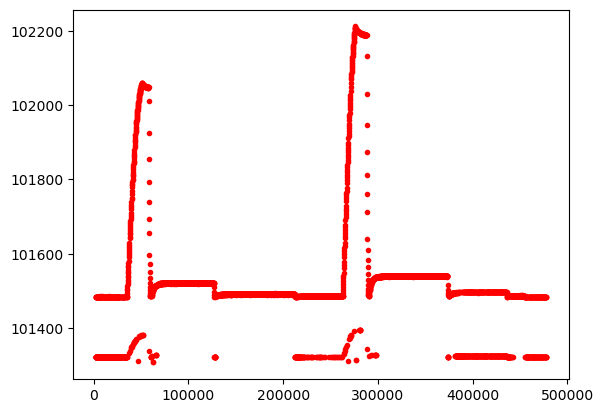

In [44]:
### Jouw code
import numpy as np 
import matplotlib.pyplot as plt 
atmospheric_Druk = 1.01305e5

data = np.loadtxt(r"C:/Users/tijnn/Documents/School/DATA.csv",delimiter=",")
Druk = data[:,1]+atmospheric_Druk
%whos
for i in range(len(Druk)):
    if Druk[i] <= 175:
        Druk[i] = Druk[i]*10
    


# Druk = Druk[Druk<100]*10
Volume = []
Tijd = data[:,0]
P1 = Druk[744]
P3 = Druk[3280]



def specifieke_warmte(P1,P3,atmospheric_Druk):
    return (np.log(P1)-np.log(atmospheric_Druk))/(np.log(P1)-np.log(P3))
print(specifieke_warmte(P1,P3,atmospheric_Druk))


plt.plot(Tijd, Druk, 'r.')
plt.figure
plt.show


## Arduino

Gebruikte arduino code, heb je verder niet nodig.

```{code} C++
#include <SPI.h>
#include <SD.h>

const int drukpin = A1;
const int CS_PIN  = SDCARD_SS_PIN;

const uint32_t SAMPLE_MS = 100;   // log-interval
const char* FNAME = "DATA.CSV";

void blink(uint8_t times, uint16_t onMs, uint16_t offMs, uint16_t pauseMs) {
  for (uint8_t i = 0; i < times; i++) {
    digitalWrite(LED_BUILTIN, HIGH);
    delay(onMs);
    digitalWrite(LED_BUILTIN, LOW);
    delay(offMs);
  }
  delay(pauseMs);
}

void fatalSd() {
  while (1) blink(3, 100, 100, 600);   // 3 snelle
}

void fatalFile() {
  while (1) blink(2, 250, 250, 800);   // 2 langzame
}

void setup() {
  pinMode(LED_BUILTIN, OUTPUT);
  digitalWrite(LED_BUILTIN, LOW);

  pinMode(drukpin, INPUT);

  // Geef voeding + SD wat tijd op batterij
  delay(800);

  // SD init met retries (zonder Serial kun je anders niks zien)
  bool ok = false;
  for (int atDrukt = 0; atDrukt < 5; atDrukt++) {
    if (SD.begin(CS_PIN)) { ok = true; break; }
    blink(1, 50, 50, 200);   // klein "ik probeer" knipje
    delay(300);
  }
  if (!ok) fatalSd();

  // Bestand aanmaken + header schrijven (1x), dan sluiten
  File f = SD.open(FNAME, FILE_WRITE);
  if (!f) fatalFile();

  // Als bestand leeg is, header toevoegen
  if (f.size() == 0) {
    f.println("time_ms,value");
  }
  f.close();

  // korte bevestiging
  blink(5, 60, 60, 300);
}

void loop() {
  static uint32_t last = 0;
  uint32_t now = millis();
  if (now - last < SAMPLE_MS) return;
  last = now;

  int value = analogRead(drukpin);

  File f = SD.open(FNAME, FILE_WRITE);
  if (!f) fatalFile();

  f.print(now);
  f.print(',');
  f.println(value);
  f.close();                 // <- belangrijk: file echt wegschrijven

  // schrijf-indicatie
  digitalWrite(LED_BUILTIN, HIGH);
  delay(10);
  digitalWrite(LED_BUILTIN, LOW);
}
```